In [1]:
# load in csv file
import csv
import numpy as np
import wave
import struct

x_trainAFile = [] # wave filename 
y_trainA = [] # label 

x_trainBFile = [] # wave filename 
y_trainB = [] # label 

# ignores all entries that are less than 2 seconds
def moreNsecs(file, N):
    f = wave.open(file)
    frames = f.readframes(-1)
    samples = struct.unpack('h'*f.getnframes(), frames)
    framerate = f.getframerate()
    t = [float(i)/framerate for i in range(len(samples))]
    if t[-1] > 2:
        return True
    else:
        return False

# ignores all entries without a label
with open('set_a.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        if not row[2]=='' and not row[2]=='label': 
            if moreNsecs(row[1],2):
                x_trainAFile.append(row[1])
                y_trainA.append(row[2])
print(len(x_trainAFile))

with open('set_b.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        if not row[2]=='' and not row[2]=='label': #and 'noisy' not in row[1]:
            fname = 'set_b/' + row[1][16:]
            new_fname = ''
            count = 0
            for c in fname:
                new_fname += c
                if c == '_' and 'noisy' not in row[1]:
                    if count == 1:
                       new_fname += '_' 
                    count += 1
            if moreNsecs(new_fname,2):
                x_trainBFile.append(new_fname)
                y_trainB.append(row[2])
print(len(x_trainBFile))

120
407


In [2]:
from pylab import *

def get_signal(file):
    f = wave.open(file)
    frames = f.readframes(-1)
    samples = struct.unpack('h'*f.getnframes(), frames)
    return samples

In [3]:
x_trainAFile[2]

'set_a/artifact__201105041959.wav'

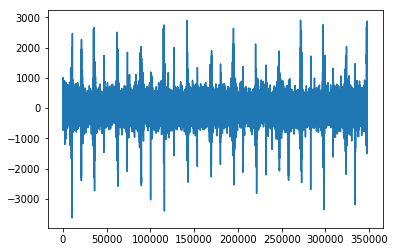

In [129]:
test = np.array(get_signal('set_a/normal__201102081321.wav'))
#test = np.array(get_signal('set_a/extrahls__201102070251.wav'))
test
figure()
plot(test)
show()

In [130]:
f = wave.open('set_a/normal__201102081321.wav')
framerate = f.getframerate()
framerate

44100

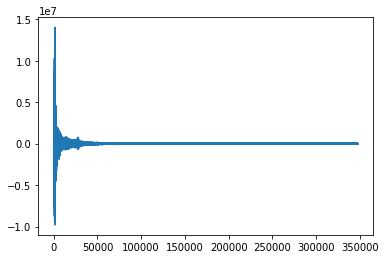

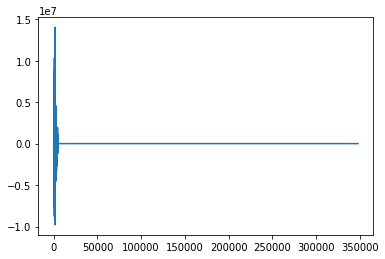

In [131]:
from scipy.fftpack import rfft, irfft, fftfreq
W = fftfreq(test.size, d=1/framerate)
f_test = rfft(test)
cut_f_test = f_test.copy()
cut_f_test[(W<2)] = 0
cut_f_test[(W>600)] = 0
figure()
plot(f_test)
figure()
plot(cut_f_test)
show()

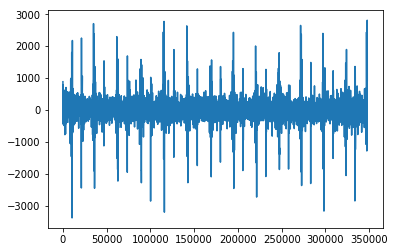

In [132]:
filtered = irfft(cut_f_test)
figure()
plot(filtered)
show()

In [133]:
# using wavelet decomposition
import pywt

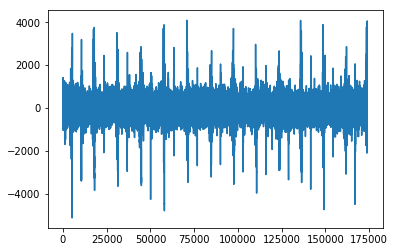

In [134]:
# 4th-level Order Six Daubechies filter
signal = pywt.dwt(test,'db4')
re_signal = signal[0].real
figure()
plot(re_signal)
show()

In [135]:
filtered = filtered/max(filtered)
re_signal = re_signal/max(abs(re_signal))
re_signal

array([0.0404229 , 0.07145275, 0.07745542, ..., 0.40512938, 0.381689  ,
       0.36907137])

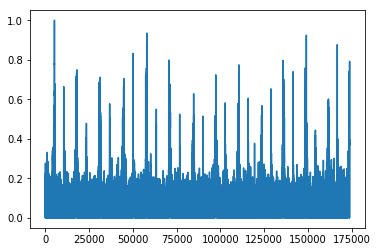

In [166]:
peaks = abs(re_signal)

figure()
plot(peaks)
show()


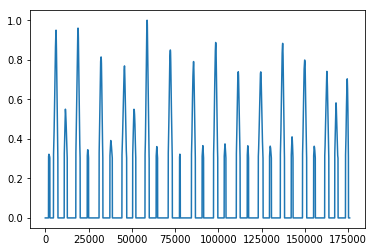

In [167]:
c = np.ones((1001))
c[500] = 5
peaks = np.convolve(peaks, c)
peaks = np.convolve(peaks, c)
peaks = peaks/max(peaks)

average = np.mean(peaks)
peaks[peaks<average] = 0

figure()
plot(peaks)
show()


In [162]:
def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    """Detect peaks in data based on their amplitude and other features.
    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height.
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).
    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.
    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`
    
    The function can handle NaN's 
    See this IPython Notebook [1]_.
    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb
    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)
    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)
    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)
    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=0, mpd=20, valley=True, show=True)
    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)
    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indexes of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indexes by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind

In [168]:
indexes = detect_peaks(peaks,mph=0.1, mpd=(0.15*framerate/2))
indexes.shape

(28,)

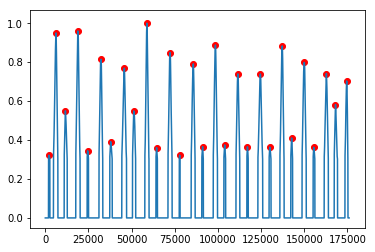

In [169]:
figure()
plot(peaks)
scatter(indexes,peaks[indexes], c='r')
show()

In [77]:
from scipy.signal import find_peaks_cwt

def find_peaks(sample):
    all_peaks = []
    #for sample in samples:
    indexes = find_peaks_cwt(sample, np.arange(1, 5))
    peaks = []
    for i in indexes:
        if sample[i] > 0.15:
            peaks.append(i)

    if len(peaks) > 1:
        i = 1
        start = 0
        tmp_array = []
        max_peak = sample[peaks[start]]
        max_ind = start
        while i < len(peaks):
            if peaks[i] <= (peaks[start] + 200):
                if sample[peaks[i]] > max_peak:
                    max_peak = sample[peaks[i]]
                    max_ind = i
                if i == len(peaks)-1:
                    tmp_array.append(peaks[max_ind])
                    break
                i += 1
            else:
                tmp_array.append(peaks[max_ind])
                start = i 
                max_ind = start
                max_peak = sample[peaks[start]]
                i += 1
        peaks = tmp_array
    all_peaks.append(peaks)
    return np.array(all_peaks)

all_peaks = find_peaks(smoothed)

/Users/ajchao/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/Users/ajchao/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


In [78]:
all_peaks

array([[  4215,   8189,  13611,  20909,  26582,  34207,  39918,  40726,
         46935,  47731,  53384,  53585,  60826,  66482,  74226,  87693,
         93098, 100528, 105876, 113505, 119089, 126521, 127498, 132175,
        139207, 144668, 151929, 157542, 164770, 170020, 171420, 176579]])

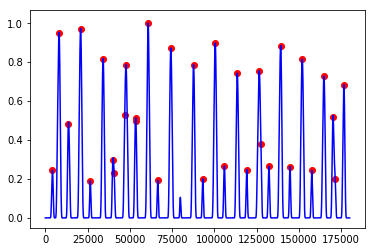

In [81]:
figure()
plot(smoothed,'b')
scatter(all_peaks,smoothed[all_peaks],c='r')
show()

In [158]:
# dataset A, import sound files
x_trainA_raw = [] # features
for i in range(len(x_trainAFile)):
    x_trainA_raw.append(np.array(get_signal(x_trainAFile[i])))
x_trainA_raw = np.array(x_trainA_raw)
print(x_trainA_raw.shape)

# dataset B, import sound files
x_trainB_raw = [] # features
for i in range(len(x_trainBFile)):
    x_trainB_raw.append(np.array(get_signal(x_trainBFile[i])))
x_trainB_raw = np.array(x_trainB_raw)
print(x_trainB_raw.shape)

(120,)
(407,)


In [159]:
# downsample by a factor of 10
def down_sample(x, factor=10):
    r = range(len(x))
    down_array = []
    for i in r[0::factor]:
        down_array.append(x[i])
    return down_array

In [160]:
print(len(x_trainA_raw[0]))
x_trainA = []
x_trainA = np.array([down_sample(sample) for sample in x_trainA_raw])
print(len(x_trainA[0]))
print(x_trainA.shape)

396900
39690
(120,)


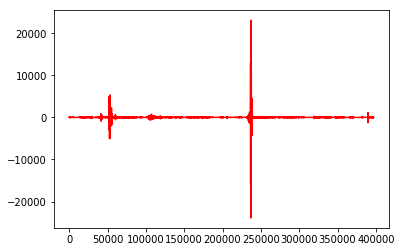

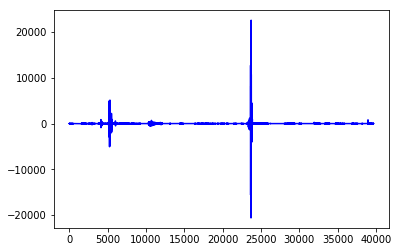

In [161]:
figure()
plot(x_trainA_raw[0],'r')
figure()
plot(x_trainA[0],'b')
show()

In [162]:
# using wavelet decomposition
import pywt

In [163]:
# 4th-level Order Six Daubechies filter
x_trainA = np.array([pywt.dwt(x,'db4')[0] for x in x_trainA])
print(len(x_trainA[0]))
print(x_trainA.shape)

19848
(120,)


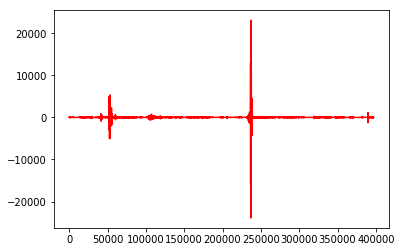

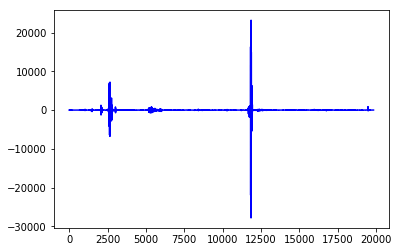

In [164]:
figure()
plot(x_trainA_raw[0],'r')
figure()
plot(x_trainA[0],'b')
show()

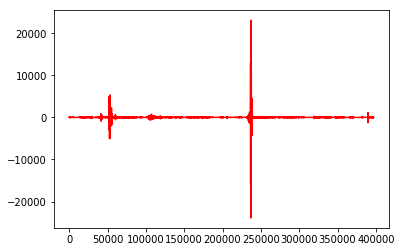

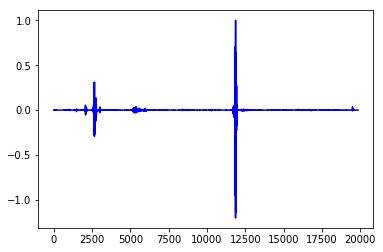

(120, 7138)


In [165]:
# normalize 
x_trainA = np.array([x/max(x) for x in x_trainA])
figure()
plot(x_trainA_raw[0],'r')
figure()
plot(x_trainA[0],'b')
show()

min_length = min(map(len, x_trainA))
x_trainA = np.array([x[:min_length] for x in x_trainA])
print(x_trainA.shape)

In [166]:
from scipy.signal import find_peaks_cwt

def find_peaks(samples):
    all_peaks = []
    for sample in samples:
        indexes = find_peaks_cwt(sample, np.arange(1, 5))
        peaks = []
        for i in indexes:
            if sample[i] > 0.15:
                peaks.append(i)

        if len(peaks) > 1:
            i = 1
            start = 0
            tmp_array = []
            max_peak = sample[peaks[start]]
            max_ind = start
            while i < len(peaks):
                if peaks[i] <= (peaks[start] + 200):
                    if sample[peaks[i]] > max_peak:
                        max_peak = sample[peaks[i]]
                        max_ind = i
                    if i == len(peaks)-1:
                        tmp_array.append(peaks[max_ind])
                        break
                    i += 1
                else:
                    tmp_array.append(peaks[max_ind])
                    start = i 
                    max_ind = start
                    max_peak = sample[peaks[start]]
                    i += 1
            peaks = tmp_array
        all_peaks.append(peaks)
    return np.array(all_peaks)

all_peaks = find_peaks(x_trainA)

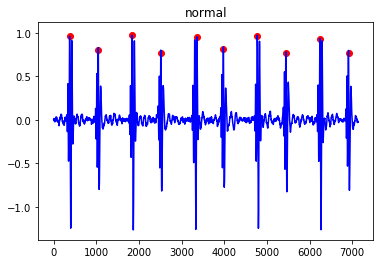

In [167]:
n = 119
figure()
title(y_trainA[n])
plot(x_trainA[n],'b')
scatter(all_peaks[n],x_trainA[n][all_peaks[n]],c='r')
show()

In [134]:
# This is what the find_peaks function does
# Uncomment to see how the find_peaks works 
'''n = 110
from scipy.signal import find_peaks_cwt
indexes = find_peaks_cwt(x_trainA[n], np.arange(1, 5))
figure()
title(y_trainA[n])
plot(x_trainA[n],'b')
scatter(indexes,x_trainA[n][indexes],c='r')
show()

peaks = []
for x in x_trainA[n:n+1]:
    for i in indexes:
        if x[i] > 0.15:
            peaks.append(i)
figure()
plot(x_trainA[n],'b')
scatter(peaks,x_trainA[n][peaks],c='r')
show()

if len(peaks) > 1:
    i = 1
    start = 0
    tmp_array = []
    max_peak = x_trainA[n][peaks[start]]
    max_ind = start
    while i < len(peaks):
        if peaks[i] <= (peaks[start] + 200):
            if x_trainA[n][peaks[i]] > max_peak:
                max_peak = x_trainA[n][peaks[i]]
                max_ind = i
            if i == len(peaks)-1:
                tmp_array.append(peaks[max_ind])
                break
            i += 1
        else:
            tmp_array.append(peaks[max_ind])
            start = i 
            max_ind = start
            max_peak = x_trainA[n][peaks[start]]
            i += 1
    peaks = tmp_array

print(peaks)
figure()
plot(x_trainA[n],'b')
scatter(peaks,x_trainA[n][peaks],c='r')
show()'''

"n = 110\nfrom scipy.signal import find_peaks_cwt\nindexes = find_peaks_cwt(x_trainA[n], np.arange(1, 5))\nfigure()\ntitle(y_trainA[n])\nplot(x_trainA[n],'b')\nscatter(indexes,x_trainA[n][indexes],c='r')\nshow()\n\npeaks = []\nfor x in x_trainA[n:n+1]:\n    for i in indexes:\n        if x[i] > 0.15:\n            peaks.append(i)\nfigure()\nplot(x_trainA[n],'b')\nscatter(peaks,x_trainA[n][peaks],c='r')\nshow()\n\nif len(peaks) > 1:\n    i = 1\n    start = 0\n    tmp_array = []\n    max_peak = x_trainA[n][peaks[start]]\n    max_ind = start\n    while i < len(peaks):\n        if peaks[i] <= (peaks[start] + 200):\n            if x_trainA[n][peaks[i]] > max_peak:\n                max_peak = x_trainA[n][peaks[i]]\n                max_ind = i\n            if i == len(peaks)-1:\n                tmp_array.append(peaks[max_ind])\n                break\n            i += 1\n        else:\n            tmp_array.append(peaks[max_ind])\n            start = i \n            max_ind = start\n            

In [168]:
# features
# 1. number of peaks
# 2. average timing between peaks  
# 3. average strength of peaks 
# 4. min peak
# 5. max peak 
# would be also nice to find s1 and s2 and get m1 and m2 but don't even know what those are yet
# TO-DO: Learn more about extrahls and murmur and their differences from normal

def get_features(x_train,all_peaks):
    features = []
    for k in range(len(all_peaks)): 
        num_peaks = len(all_peaks[k])
        avg_between = 0
        avg_strength = 0
        if len(all_peaks[k]) == 1:
            avg_strength = x_train[k][all_peaks[k]]
        min_peak = 0
        max_peak = 0
        if num_peaks > 1:
            for i in range(1,len(all_peaks[k])):
                avg_between += np.abs(all_peaks[k][i] - all_peaks[k][i-1])
            avg_between /= len(all_peaks[k]) - 1
            min_peak = min(x_train[n][all_peaks[k]])
            max_peak = max(x_train[n][all_peaks[k]])
            for i in range(1,len(all_peaks[k])):
                avg_strength += x_train[n][all_peaks[k][i]]
            avg_strength /= len(all_peaks[k])
        features.append([num_peaks,avg_between,avg_strength,min_peak,max_peak])
    features = np.array(features)
    maxes = np.amax(features,axis=0)
    for feature in features:
        feature = np.array([feature[0]/maxes[0],feature[1]/maxes[1],feature[2]/maxes[2],feature[3]/maxes[3],feature[4]/maxes[4]])
    return features 

features = get_features(x_trainA,all_peaks)

In [169]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_trainA = le.fit_transform(y_trainA) # 0 - artifact, 1 - extrahls, 2 - murmur, 3 - normal

In [170]:
from sklearn import svm
from sklearn.model_selection import KFold

# split into train/test
# TO-DO: this is just my lazy way of splitting into train test, will do it properly with randomless later
kf = KFold(n_splits=5)
results = []
for tr, ts in kf.split(features):
    print("Performing training on fold...")
    clf = svm.SVC(C=70,probability=True, kernel='rbf')
    #clf.fit(x_trainA[tr], y_trainA[tr])
    results.append(clf.fit(features[tr], y_trainA[tr]).score(features[ts],y_trainA[ts]))
print(np.average(results))

Performing training on fold...
Performing training on fold...
Performing training on fold...
Performing training on fold...
Performing training on fold...
0.208333333333
